In [2]:
import yfinance as yf, pandas as pd, shutil, os, time, glob
import numpy as np
import requests
from get_all_tickers import get_tickers as gt
from statistics import mean
import talib
import matplotlib.pyplot as plt

In [3]:
# Get the path for each stock file in a list
list_files = (glob.glob("/Users/ks/bot/Pynance/yfinance/stock_data_min/*.csv"))
# Create the dataframe that we will be adding the final analysis of each stock to
stock = list_files[0]

In [4]:
    hist_data = pd.read_csv(stock)
    # Name of company
    company = ((os.path.basename(stock)).split(".csv")[0]) 
    # Append the closing prices of a stock in prices list
    prices = []
    c = 0
    # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
    while c < len(hist_data):
        if hist_data.iloc[c,4] > float(2.00):
            prices.append(hist_data.iloc[c,4])
        c += 1
    # prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list
    i = 0
    up_prices=[]
    down_prices=[]
    #  Loop to hold up and down price difference 
    while i < len(prices):
        if i == 0:
            up_prices.append(0)
            down_prices.append(0)
        else:
            if (prices[i]-prices[i-1])>0:
                up_prices.append(prices[i]-prices[i-1])
                down_prices.append(0)
            else:
                down_prices.append(prices[i]-prices[i-1])
                up_prices.append(0)
        i += 1

    x = 0
    avg_gain = []
    avg_loss = []
    #  Loop to calculate the average gain and loss
    while x < len(up_prices):
        if x < 15:
            avg_gain.append(0)
            avg_loss.append(0)
        else:
            sum_gain = 0
            sum_loss = 0
            y = x-14
            while y < x:
                sum_gain += up_prices[y]
                sum_loss += down_prices[y]
                y += 1
            avg_gain.append(sum_gain/14)
            avg_loss.append(abs(sum_loss/14))
        x += 1

    p = 0
    RS = []
    RSI = []
    #  Loop to calculate RSI and RS
    while p < len(prices):
        if p <15:
            RS.append(0)
            RSI.append(0)
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1+RSvalue)))
        p+=1


In [6]:
real = talib.RSI(hist_data['Close'], timeperiod=14)

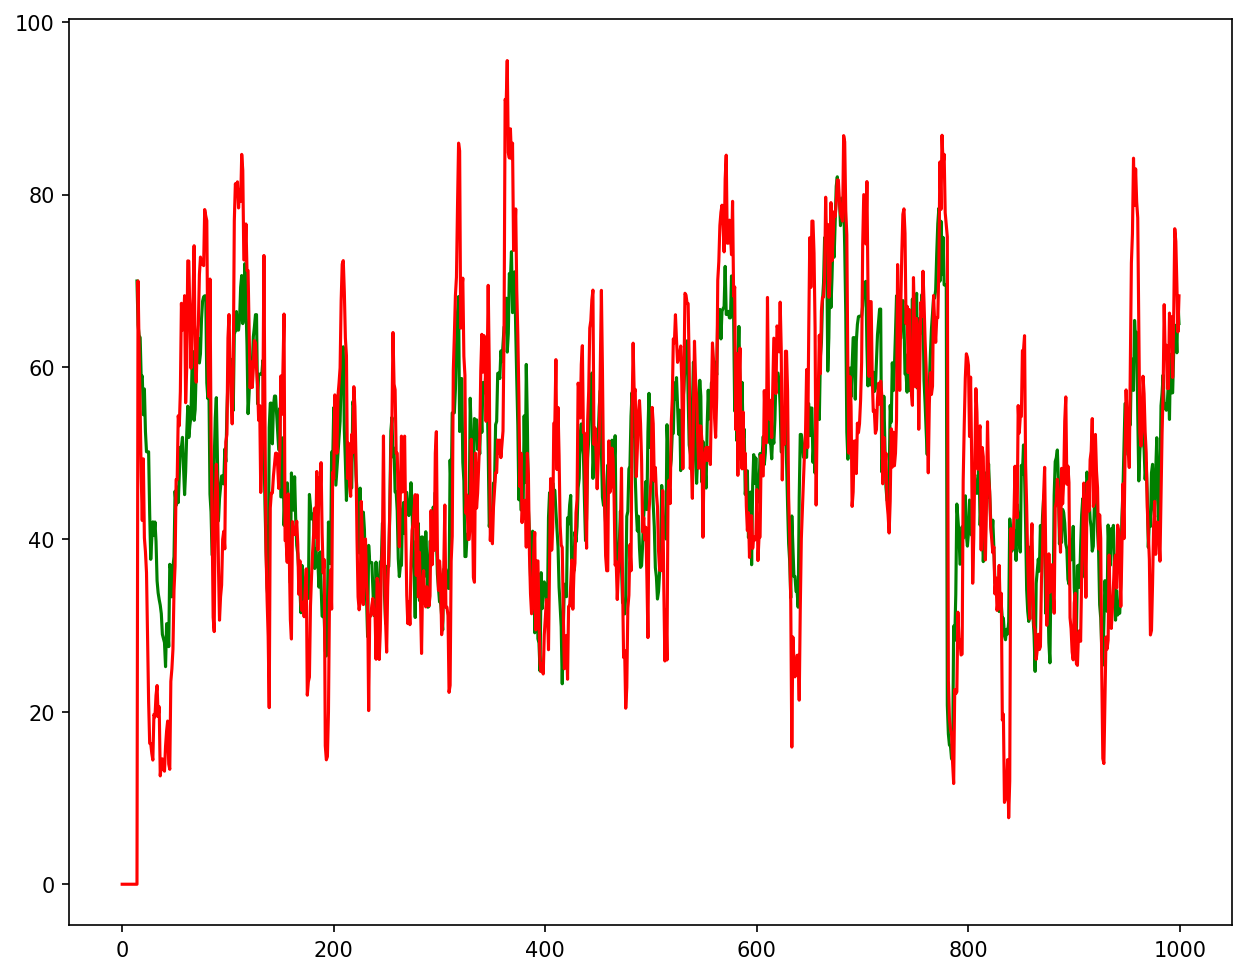

In [33]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
plt.plot(real[:1000], 'g')
plt.plot(RSI[:1000] , 'r')

plt.show()